In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

# from sklearn.svm import LinearSVC
# from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
# from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.externals import joblib()


In [6]:
# df_scraped = pd.read_csv('../input/labeled-tweets/labeled_tweets.csv')
# df_public = pd.read_csv('../input/public-dataset/public_data_labeled.csv')
# df_scraped.drop_duplicates(inplace = True)
# df_scraped.drop('id', axis = 'columns', inplace = True)

# df_public.drop_duplicates(inplace = True)
# df_scraped.head(2)
df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')

In [7]:
# df = pd.concat([df_scraped, df_public])
df.shape

(159571, 8)

In [8]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

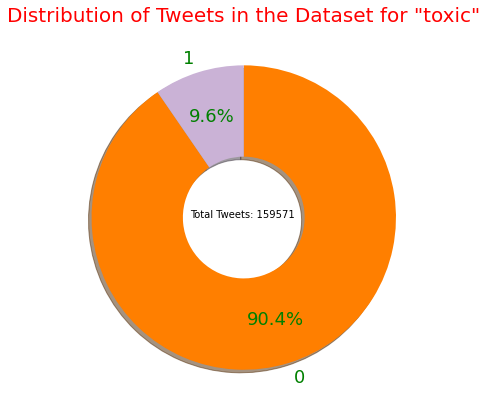

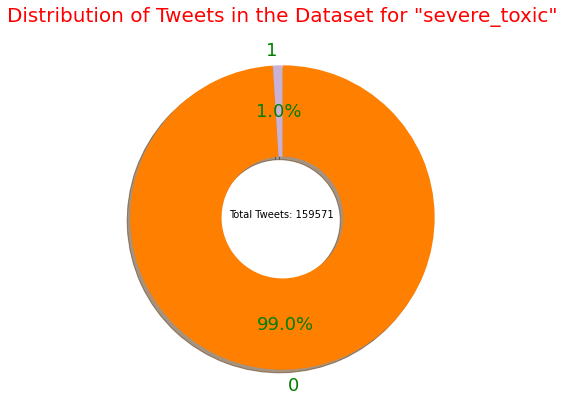

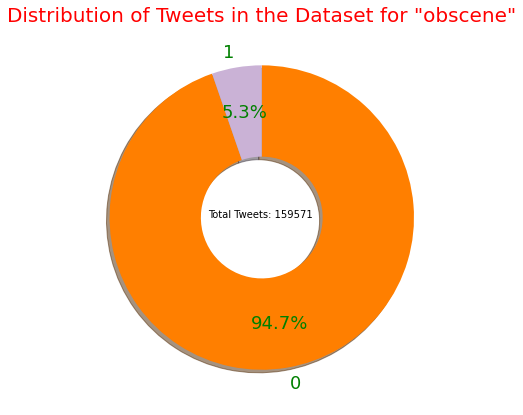

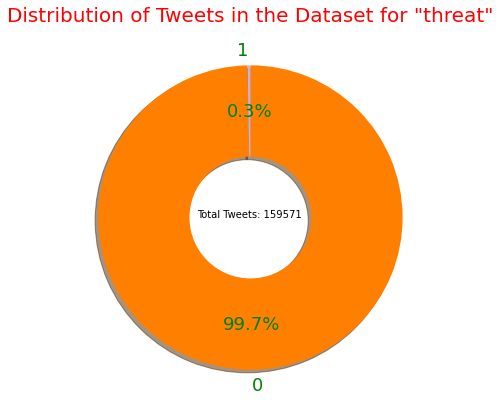

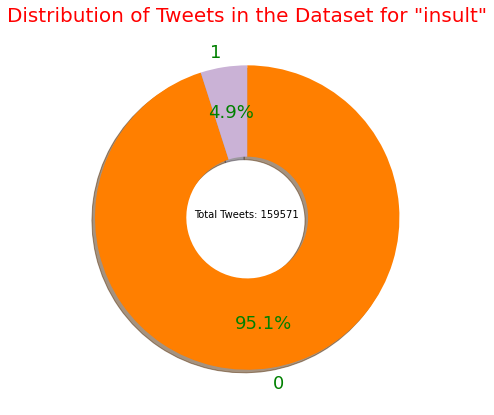

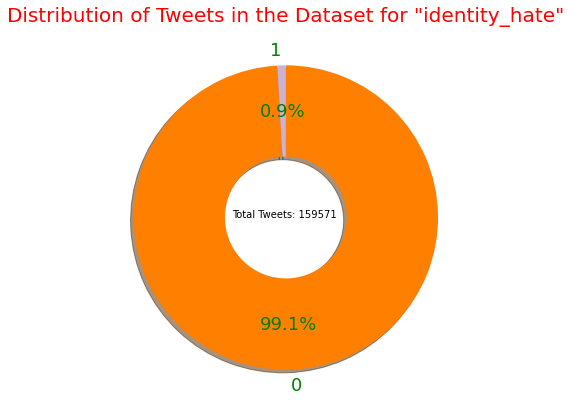

In [11]:
for i in range(2,8):
    import matplotlib.pyplot as plt
    plt.figure(figsize = (7,7))
    sorted_counts = df[df.columns[i]].value_counts()
    plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
           autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'green', 'fontsize' : 18}, shadow = True,
            colors = sns.color_palette("Paired")[7:])
    plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
    plt.title(f'Distribution of Tweets in the Dataset for "{df.columns[i]}"', fontsize = 20, color = 'red');
    plt.savefig(f'distribution_{df.columns[i]}.png')


**Implementing a training and predicting Pipeline
Separate training and testing data:**

In [12]:
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1]], 
                                                    df[df.columns[2:]], 
                                                    random_state=512)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))
print(f"test_size : {round(X_test.shape[0]/df.shape[0],4)*100}%")

Number of rows in the total set: 159571
Number of rows in the training set: 119678
Number of rows in the test set: 39893
test_size : 25.0%


**Vectorize the data:**

In [13]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

**Implement Pipeline:**

In [16]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)
                                                      
      # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results


**Put Algorithms in Pipeline:**

In [17]:
# make a list of models
# models = [MultinomialNB(), KNeighborsClassifier(),DecisionTreeClassifier(), ,  
#           RandomForestClassifier(), SGDClassifier() , LogisticRegression(), , ]
models = [MultinomialNB(),  DecisionTreeClassifier(), KNeighborsClassifier(), SGDClassifier(),  RandomForestClassifier(),  
           GradientBoostingClassifier(),  SVC()]

mm = []

m  = [LogisticRegression()
           ]

In [25]:
# y_train.iloc[:,0].shape

In [26]:
# y_train

In [27]:
# training_data

In [28]:
# testing_data

In [29]:
# training_data.toarray()

# **toxic**

**Analyze the results of the Pipeline**

In [30]:
re = pipeline(models, training_data, y_train.iloc[:,0], testing_data, y_test.iloc[:,0])
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training MultinomialNB
Training MultinomialNB finished in 0.04 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 181.08 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.01 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.68 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 707.73 sec
----------------------------------------------------
Training GradientBoostingClassifier
Training GradientBoostingClassifier finished in 54.97 sec
----------------------------------------------------
Training SVC
Training SVC finished in 1626.63 sec
----------------------------------------------------


In [31]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

In [32]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,SGDClassifier,0.956559,0.878574,0.627253,0.731941,0.018071,0.968724,0.948875,0.713591,0.814584,0.683104
1,RandomForestClassifier,0.953526,0.867997,0.599682,0.709313,31.181802,0.999808,0.999305,0.998698,0.999002,707.731587
2,MultinomialNB,0.949640,0.818346,0.600742,0.692860,0.039008,0.955238,0.808961,0.700486,0.750826,0.039309
3,DecisionTreeClassifier,0.937708,0.669387,0.674178,0.671774,0.628271,0.999816,0.999826,0.998264,0.999045,181.081726
4,SVC,0.942872,0.946738,0.419406,0.581297,835.363641,0.944409,0.955984,0.442979,0.605421,1626.626184
5,GradientBoostingClassifier,0.939889,0.923551,0.397137,0.555432,0.250758,0.938736,0.927726,0.394376,0.553471,54.969408
6,KNeighborsClassifier,0.928885,0.839014,0.306734,0.449233,819.850071,0.937156,0.910527,0.385089,0.541263,0.014372


In [33]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.928885,0.669387,0.306734,0.449233,0.018071,0.937156,0.808961,0.385089,0.541263,0.014372
max,0.956559,0.946738,0.674178,0.731941,835.363641,0.999816,0.999826,0.998698,0.999045,1626.626184


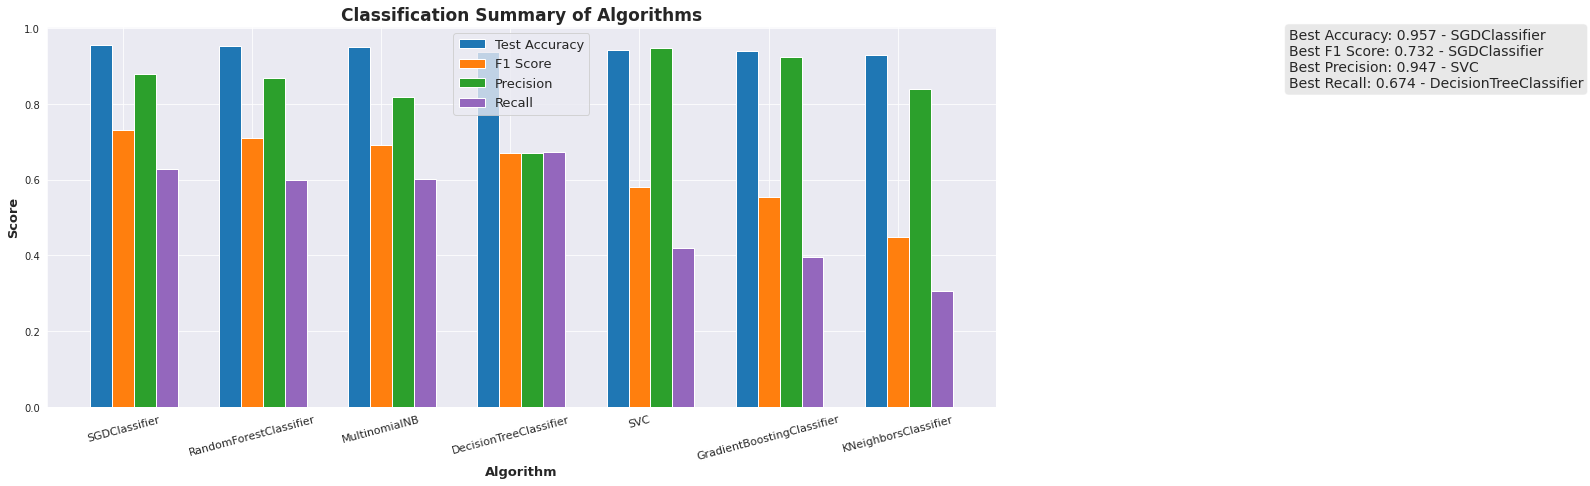

In [35]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);
plt.savefig(f'AccuracyGraph_{y_train.columns[0]}.png')

In [36]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

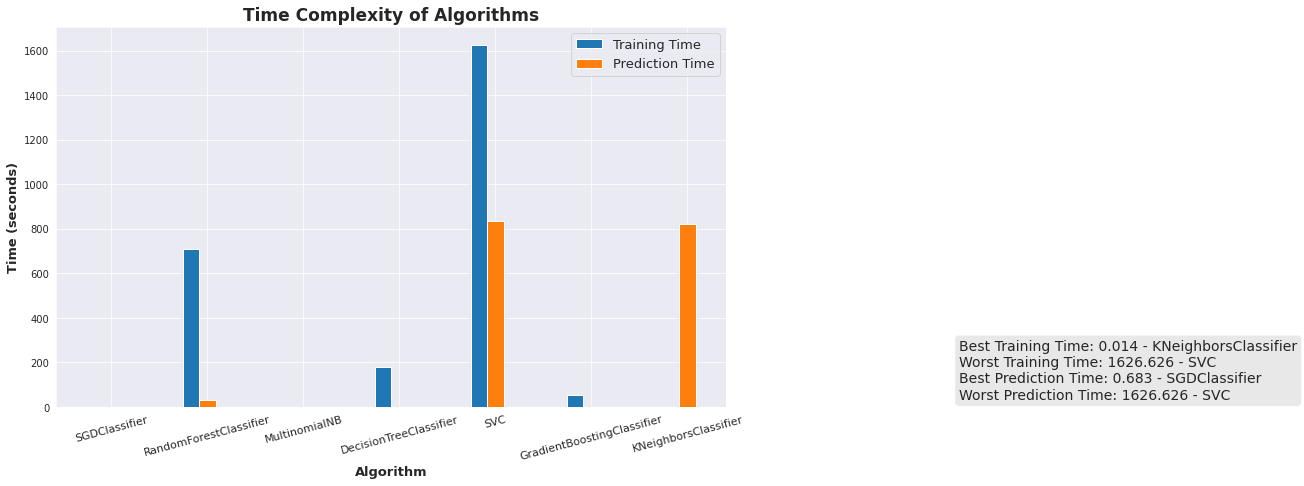

In [37]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17)
plt.savefig(f'TimeEvaluation_{y_train.columns[0]}.png')

# **severe_toxic**

In [18]:
re = pipeline(models, training_data, y_train.iloc[:,1], testing_data, y_test.iloc[:,1])
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

Training MultinomialNB
Training MultinomialNB finished in 0.04 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 43.53 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.01 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.51 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 245.28 sec
----------------------------------------------------
Training GradientBoostingClassifier
Training GradientBoostingClassifier finished in 53.88 sec
----------------------------------------------------
Training SVC
Training SVC finished in 552.61 sec
----------------------------------------------------


In [19]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,MultinomialNB,0.987792,0.390777,0.405542,0.398022,0.040920,0.988126,0.429116,0.563439,0.487189,0.036418
1,DecisionTreeClassifier,0.987065,0.320242,0.267003,0.291209,0.291094,0.999799,0.996616,0.983306,0.989916,43.534552
2,KNeighborsClassifier,0.989296,0.414773,0.183879,0.254799,819.139055,0.991937,0.706195,0.333055,0.452638,0.012991
3,SGDClassifier,0.989271,0.411429,0.181360,0.251748,0.019130,0.991176,0.651064,0.255426,0.366906,0.508635
4,GradientBoostingClassifier,0.989597,0.432836,0.146096,0.218456,0.258153,0.992497,0.809917,0.327212,0.466112,53.878554
5,RandomForestClassifier,0.989672,0.411765,0.088161,0.145228,19.567158,0.999799,0.993277,0.986644,0.989950,245.281512
6,SVC,0.990048,0.500000,0.005038,0.009975,235.094155,0.990859,0.990566,0.087646,0.161043,552.605941


In [20]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.987065,0.320242,0.005038,0.009975,0.019130,0.988126,0.429116,0.087646,0.161043,0.012991
max,0.990048,0.500000,0.405542,0.398022,819.139055,0.999799,0.996616,0.986644,0.989950,552.605941


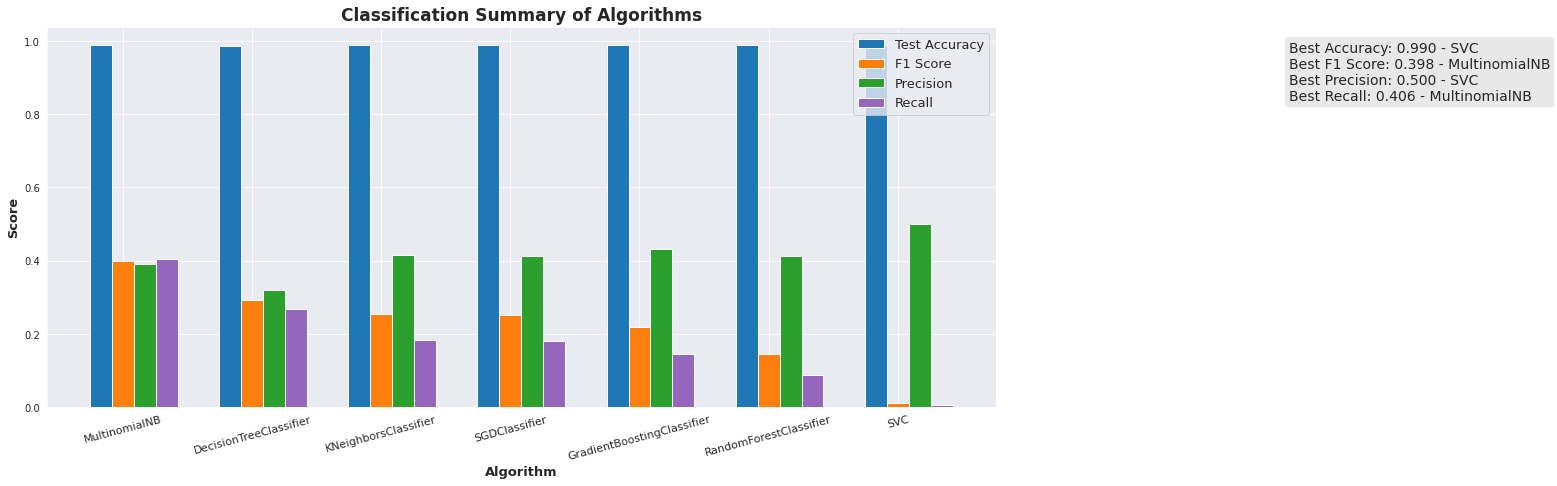

In [21]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);
plt.savefig(f'AccuracyGraph_{y_train.columns[1]}.png')

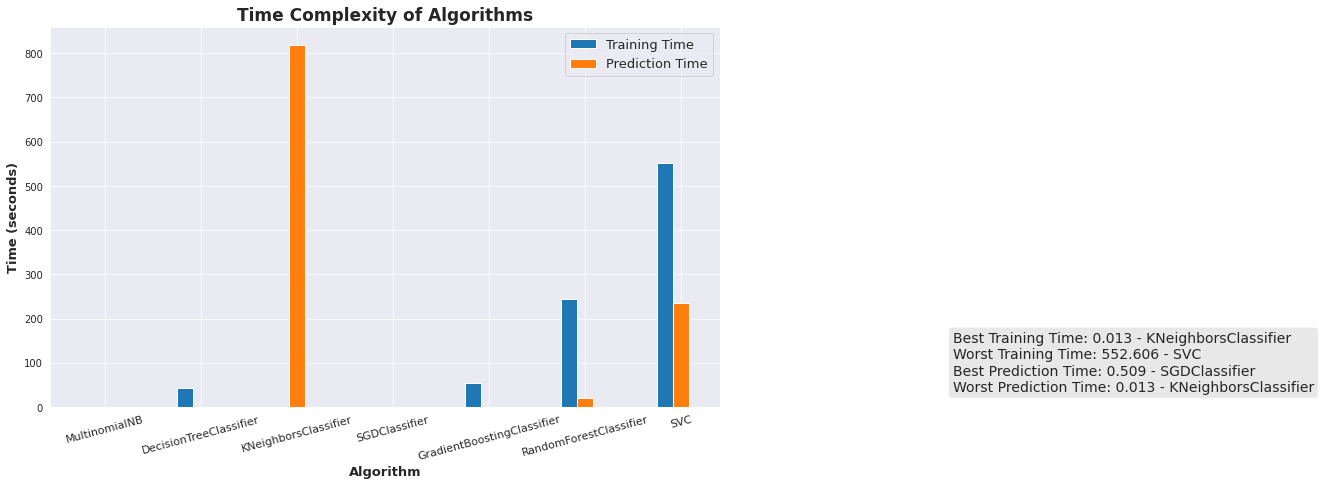

In [22]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17)
plt.savefig(f'TimeEvaluation_{y_train.columns[1]}.png')

# **obscene**

In [23]:
re = pipeline(models, training_data, y_train.iloc[:,2], testing_data, y_test.iloc[:,2])
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

Training MultinomialNB
Training MultinomialNB finished in 0.04 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 91.70 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.02 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.92 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 487.48 sec
----------------------------------------------------
Training GradientBoostingClassifier
Training GradientBoostingClassifier finished in 58.82 sec
----------------------------------------------------
Training SVC
Training SVC finished in 1099.80 sec
----------------------------------------------------


In [24]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,RandomForestClassifier,0.978818,0.879147,0.698353,0.778390,29.534073,0.999825,0.998576,0.998102,0.998339,487.475518
1,SGDClassifier,0.977490,0.859402,0.690353,0.765658,0.017319,0.985210,0.936876,0.772138,0.846567,0.924955
2,DecisionTreeClassifier,0.973930,0.753861,0.758118,0.755983,0.310550,0.999825,0.999841,0.996837,0.998337,91.702028
3,MultinomialNB,0.970596,0.785714,0.616000,0.690583,0.038424,0.971992,0.748828,0.707147,0.727391,0.042917
4,GradientBoostingClassifier,0.972075,0.890951,0.542118,0.674078,0.253872,0.973997,0.916710,0.558665,0.694242,58.818198
5,SVC,0.972151,0.916941,0.524706,0.667465,428.128476,0.975041,0.937353,0.565465,0.705395,1099.801207
6,KNeighborsClassifier,0.965006,0.908175,0.381647,0.537442,781.100928,0.970462,0.947098,0.467109,0.625649,0.015094


In [25]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.965006,0.753861,0.381647,0.537442,0.017319,0.970462,0.748828,0.467109,0.625649,0.015094
max,0.978818,0.916941,0.758118,0.778390,781.100928,0.999825,0.999841,0.998102,0.998339,1099.801207


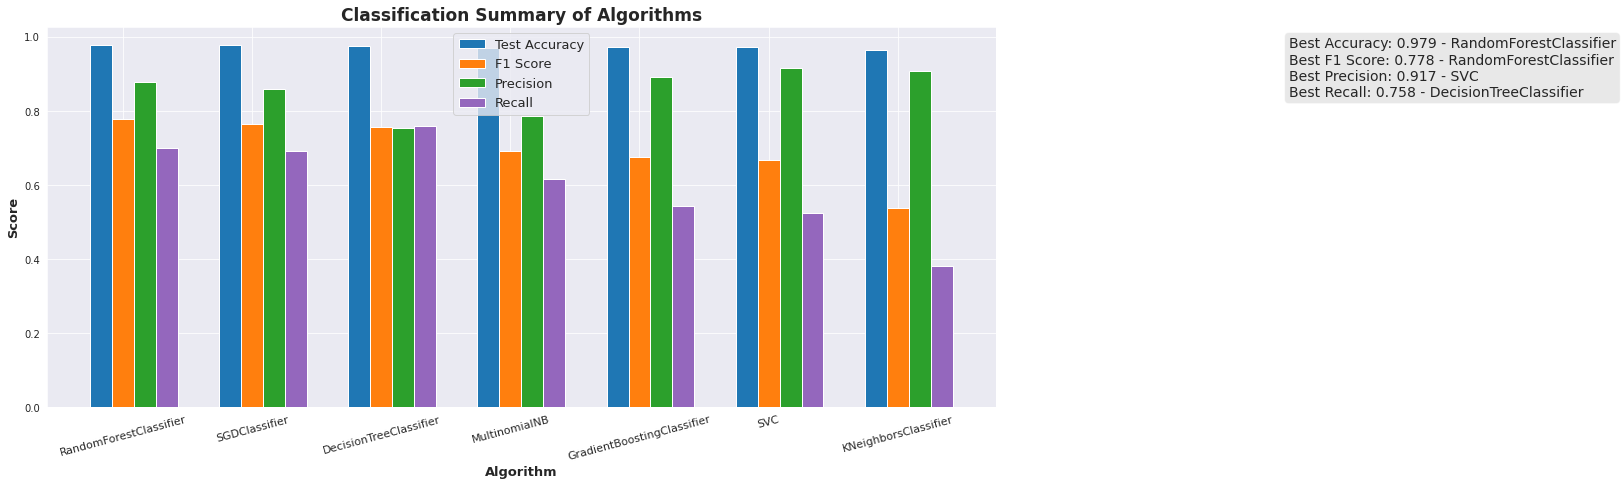

In [26]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);
plt.savefig(f'AccuracyGraph_{y_train.columns[2]}.png')

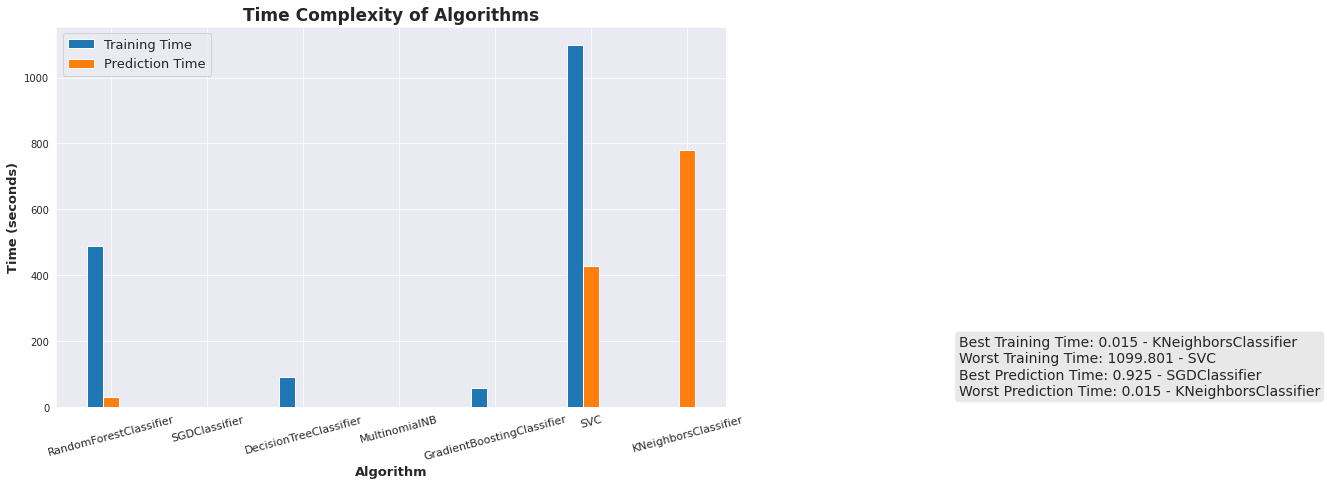

In [27]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17)
plt.savefig(f'TimeEvaluation_{y_train.columns[2]}.png')

# **threat**

In [28]:
re = pipeline(models, training_data, y_train.iloc[:,3], testing_data, y_test.iloc[:,3])
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

Training MultinomialNB
Training MultinomialNB finished in 0.04 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 22.72 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.01 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.72 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 107.13 sec
----------------------------------------------------
Training GradientBoostingClassifier
Training GradientBoostingClassifier finished in 48.32 sec
----------------------------------------------------
Training SVC
Training SVC finished in 281.21 sec
----------------------------------------------------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,DecisionTreeClassifier,0.995062,0.243697,0.213235,0.227451,0.099349,0.999958,1.000000,0.985380,0.992636,22.715486
1,SGDClassifier,0.996115,0.333333,0.139706,0.196891,0.018425,0.997719,0.841584,0.248538,0.383747,0.717187
2,MultinomialNB,0.996215,0.258065,0.058824,0.095808,0.035294,0.996081,0.184080,0.108187,0.136280,0.038374
3,GradientBoostingClassifier,0.996165,0.225806,0.051471,0.083832,0.248969,0.996950,0.394495,0.125731,0.190687,48.322798
4,RandomForestClassifier,0.996616,0.545455,0.044118,0.081633,13.299412,0.999958,1.000000,0.985380,0.992636,107.133584
5,KNeighborsClassifier,0.996541,0.375000,0.022059,0.041667,787.835027,0.997209,0.666667,0.046784,0.087432,0.012830
6,SVC,0.996591,0.000000,0.000000,0.000000,136.354811,0.997243,1.000000,0.035088,0.067797,281.214800


In [30]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.995062,0.000000,0.000000,0.000000,0.018425,0.996081,0.18408,0.035088,0.067797,0.01283
max,0.996616,0.545455,0.213235,0.227451,787.835027,0.999958,1.00000,0.985380,0.992636,281.21480


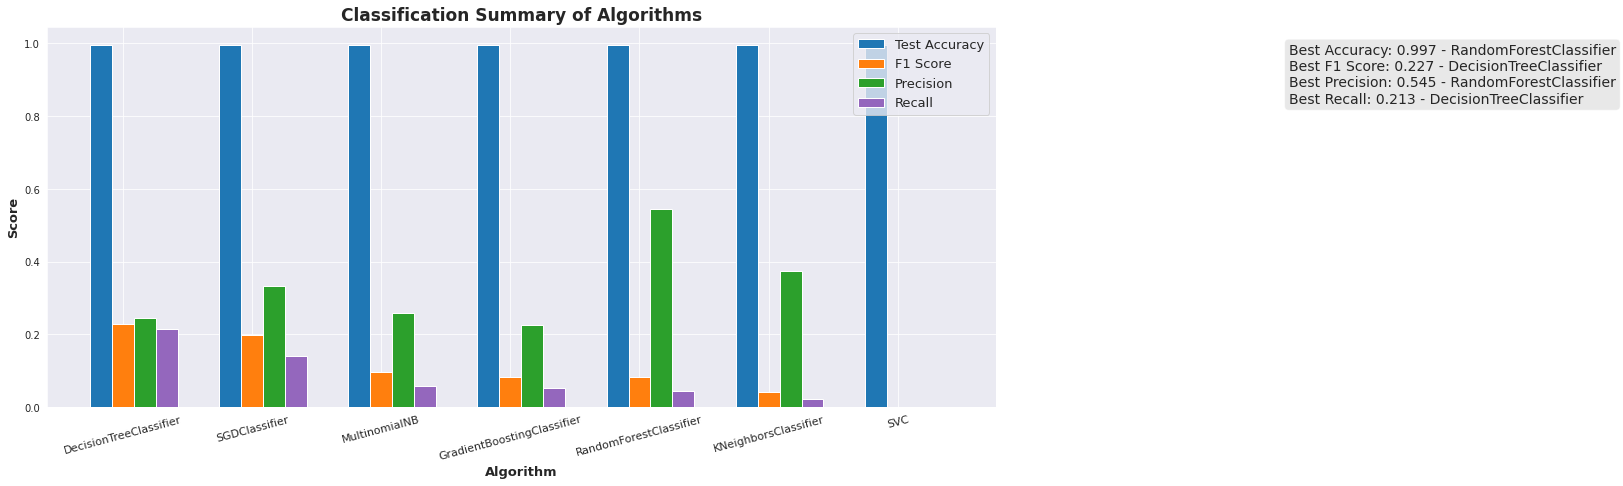

In [31]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);
plt.savefig(f'AccuracyGraph_{y_train.columns[3]}.png')

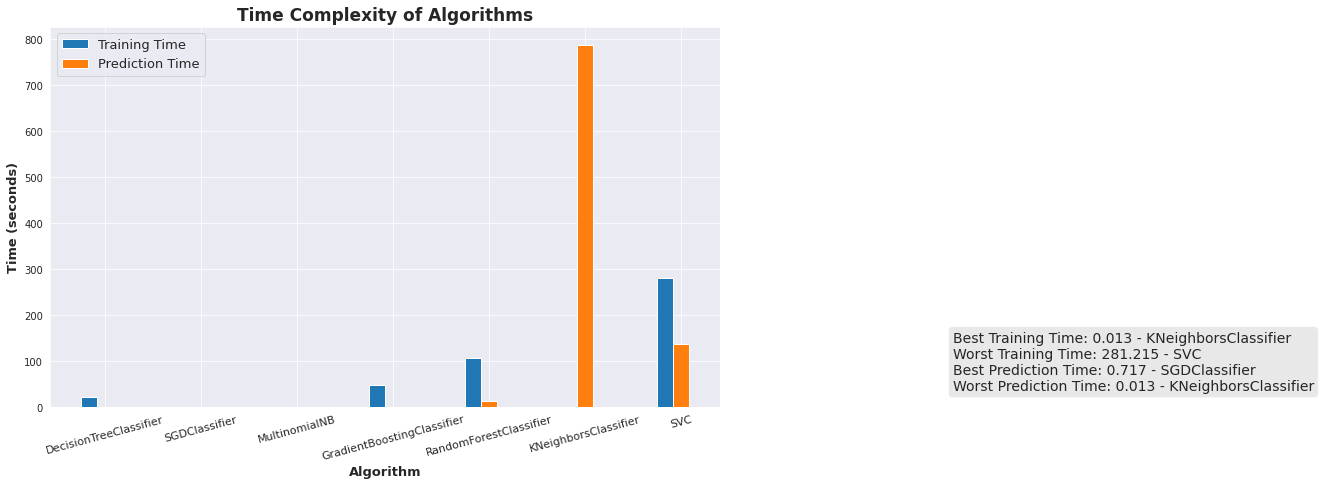

In [32]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17)
plt.savefig(f'TimeEvaluation_{y_train.columns[3]}.png')

In [ ]:
4

# **insult**

In [33]:
re = pipeline(models, training_data, y_train.iloc[:,4], testing_data, y_test.iloc[:,4])
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

Training MultinomialNB
Training MultinomialNB finished in 0.07 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 128.19 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.01 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 1.38 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 565.55 sec
----------------------------------------------------
Training GradientBoostingClassifier
Training GradientBoostingClassifier finished in 61.87 sec
----------------------------------------------------
Training SVC
Training SVC finished in 851.04 sec
----------------------------------------------------


In [34]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,SGDClassifier,0.969945,0.788316,0.530373,0.634117,0.018130,0.978217,0.895769,0.633153,0.741907,1.377088
1,RandomForestClassifier,0.969017,0.777011,0.517611,0.621324,29.279654,0.999716,0.996456,0.997803,0.997129,565.550101
2,MultinomialNB,0.966811,0.707924,0.551812,0.620195,0.081889,0.967321,0.680843,0.638391,0.658934,0.069800
3,DecisionTreeClassifier,0.962224,0.618449,0.602348,0.610292,0.441697,0.999724,0.998475,0.995945,0.997208,128.187951
4,SVC,0.966561,0.843030,0.392037,0.535192,430.763523,0.967571,0.854015,0.415174,0.558727,851.039942
5,GradientBoostingClassifier,0.964881,0.827465,0.359877,0.501601,0.258337,0.965115,0.845149,0.360595,0.505508,61.870635
6,KNeighborsClassifier,0.961497,0.790123,0.294028,0.428571,790.032742,0.967037,0.876670,0.387969,0.537894,0.014960


In [35]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.961497,0.618449,0.294028,0.428571,0.018130,0.965115,0.680843,0.360595,0.505508,0.014960
max,0.969945,0.843030,0.602348,0.634117,790.032742,0.999724,0.998475,0.997803,0.997208,851.039942


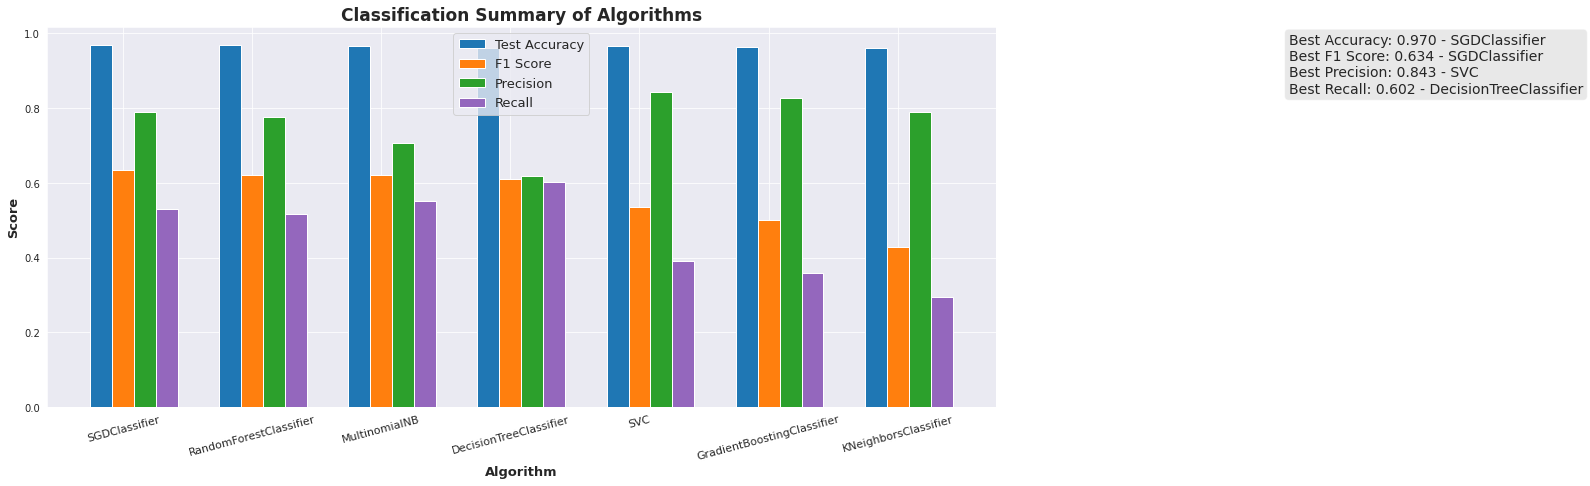

In [36]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);
plt.savefig(f'AccuracyGraph_{y_train.columns[4]}.png')

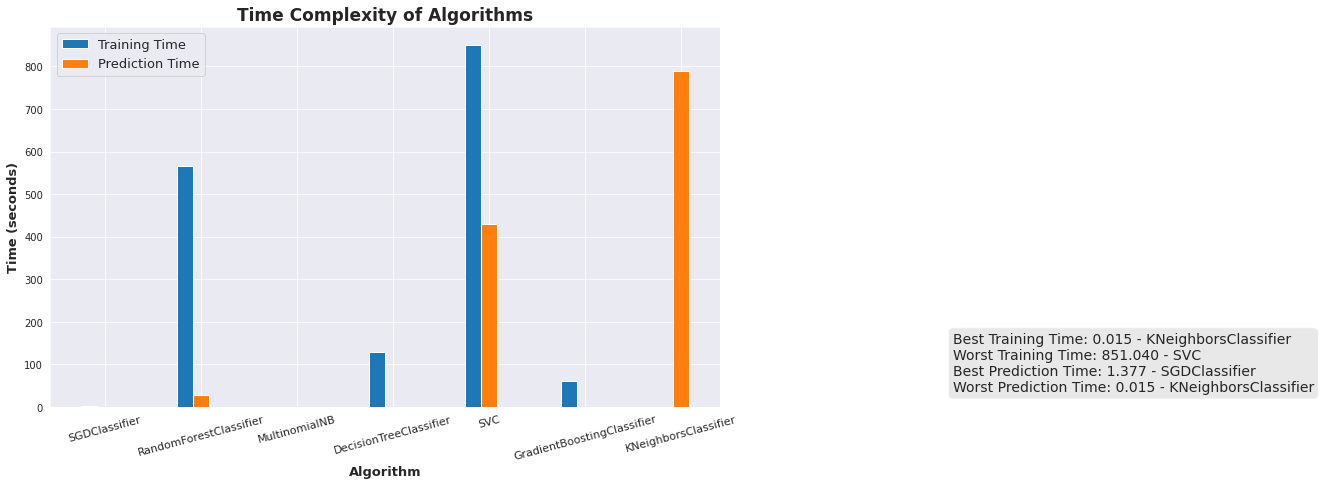

In [37]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17)
plt.savefig(f'TimeEvaluation_{y_train.columns[4]}.png')

# **identity_hate**

In [38]:
re = pipeline(models, training_data, y_train.iloc[:,5], testing_data, y_test.iloc[:,5])
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

Training MultinomialNB
Training MultinomialNB finished in 0.04 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 58.82 sec
----------------------------------------------------
Training KNeighborsClassifier
Training KNeighborsClassifier finished in 0.01 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 1.02 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 223.15 sec
----------------------------------------------------
Training GradientBoostingClassifier
Training GradientBoostingClassifier finished in 54.70 sec
----------------------------------------------------
Training SVC
Training SVC finished in 572.83 sec
----------------------------------------------------


In [39]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,DecisionTreeClassifier,0.989647,0.401961,0.348442,0.373293,0.208685,0.999908,0.999041,0.990494,0.994749,58.819134
1,GradientBoostingClassifier,0.991452,0.544776,0.206799,0.299795,0.260278,0.994494,0.870056,0.439163,0.583702,54.695173
2,RandomForestClassifier,0.991452,0.600000,0.101983,0.174334,22.653363,0.999900,0.998084,0.990494,0.994275,223.153418
3,MultinomialNB,0.989497,0.270833,0.110482,0.156942,0.038423,0.989305,0.358911,0.275665,0.311828,0.044543
4,KNeighborsClassifier,0.991076,0.473684,0.076487,0.131707,793.777064,0.992004,0.746114,0.136882,0.231325,0.013120
5,SGDClassifier,0.989748,0.250000,0.079320,0.120430,0.018085,0.992547,0.866972,0.179658,0.297638,1.021739
6,SVC,0.991201,1.000000,0.005666,0.011268,296.666270,0.991552,1.000000,0.038973,0.075023,572.826598


In [40]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.989497,0.25,0.005666,0.011268,0.018085,0.989305,0.358911,0.038973,0.075023,0.013120
max,0.991452,1.00,0.348442,0.373293,793.777064,0.999908,1.000000,0.990494,0.994749,572.826598


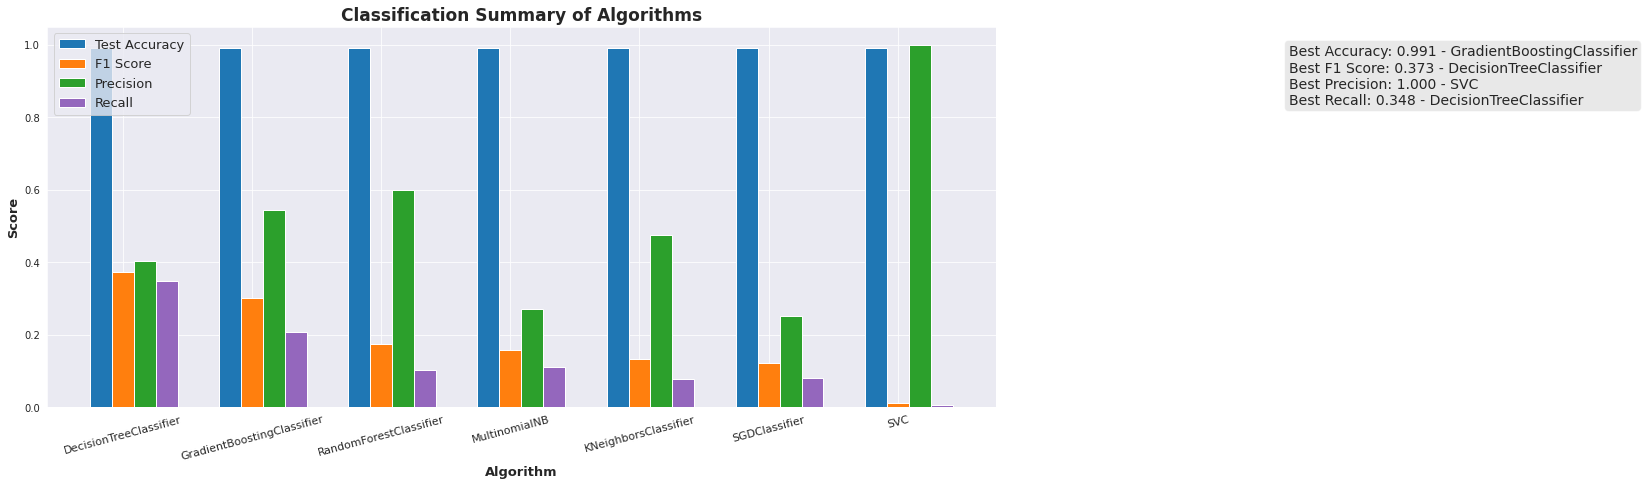

In [41]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);
plt.savefig(f'AccuracyGraph_{y_train.columns[5]}.png')

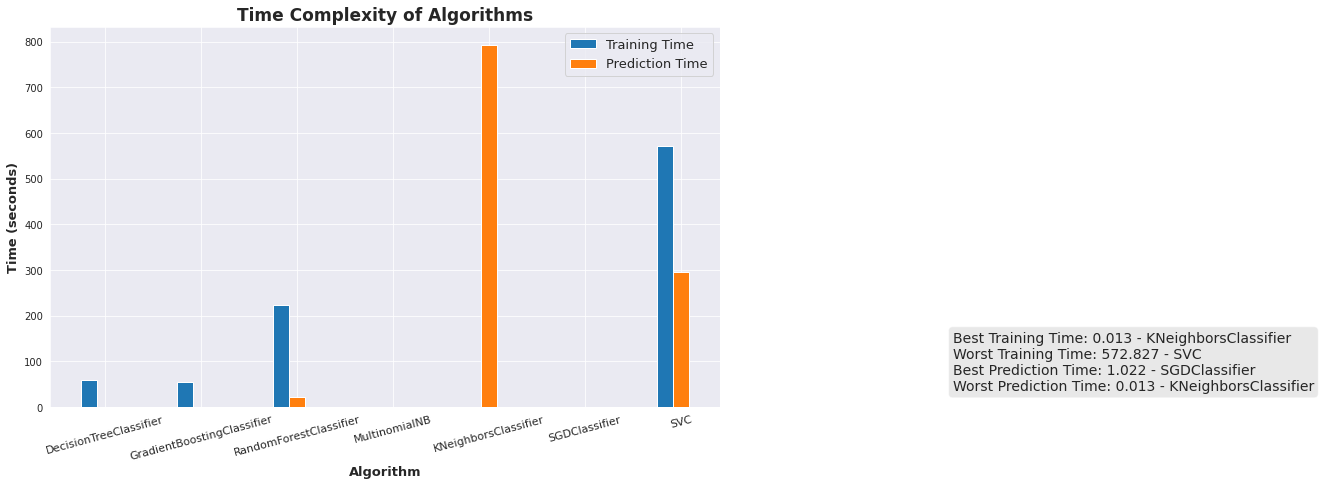

In [42]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]


plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17)
plt.savefig(f'TimeEvaluation_{y_train.columns[5]}.png')

In [3]:
# for i  in range(6):
# #     if i==0:
# #         training_data_new = training_data.toarray()
# #         testing_data_new = testing_data.toarray()
# #     if i==4:
# #         continue
#     re = pipeline(models, training_data, y_train.iloc[:,i], testing_data, y_test.iloc[:,i])
#     results = pd.DataFrame(re)
#     results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
#                               'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])
#     results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)
#     results.reset_index(drop = True)
#     results.describe().loc[['min', 'max'], :]
#     # store the best metric scores
#     best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
#     best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
#     best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
#     best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]
#     sns.set_style('darkgrid')
#     plt.figure(figsize = (17, 7))

#     barWidth = 0.17

#     # set height of bar
#     bars1 = results['Accuracy: Test']
#     bars2 = results['F1 Score: Test']
#     bars3 = results['Precision: Test']
#     bars4 = results['Recall: Test']


#     # Set position of bar on X axis
#     r1 = np.arange(len(bars1))
#     r2 = [x + barWidth for x in r1]
#     r3 = [x + barWidth for x in r2]
#     r4 = [x + barWidth for x in r3]


#     # Make the plot
#     pal = sns.color_palette()
#     plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
#     plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
#     plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
#     plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')


#     # Add xticks on the middle of the group bars
#     plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
#     plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
#     plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

#     # Create legend & Show graphic
#     plt.legend(fontsize = 13)

#     textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
#                          'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
#                        'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
#                         'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
#     props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#     #place a text box
#     plt.text(9.2, 1, textstr, fontsize=14,
#             verticalalignment='top', bbox=props)

#     plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);
    
#     plt.figure(figsize = (12, 7))

#     barWidth = 0.17

#     # set height of bar
#     bars1 = results['Training Time']
#     bars2 = results['Prediction Time']

#     # Set position of bar on X axis
#     r1 = np.arange(len(bars1))
#     r2 = [x + barWidth for x in r1]

#     # Make the plot
#     plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
#     plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')

#     # Add xticks on the middle of the group bars
#     plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
#     plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
#     plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

#     # Create legend & Show graphic
#     plt.legend(fontsize = 13)

#     textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
#                          'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
#                        'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
#                         'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

#     props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#     #place a text box
#     plt.text(9, 36, textstr, fontsize=14,  bbox=props)

#     plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);